## 2023 Open Science Data Challenge - Sentinel-2 Phenology with Cloud Filtering

This notebook calculates vegetation phenology using Sentinel-2 data with cloud filtering. This pixel-based approach is better than a scene-based approach since clouds are quite random for any given time and location. To address phenology, the algorithm uses the Normalized Difference Vegetation Index (NDVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [4]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Science
import numpy as np
import pandas as pd
import xarray as xr

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba
import time
import os
from tqdm import tqdm

### Load the crop data

In [5]:
crop_presence_data = pd.read_csv("../../data/Crop_Location_Data.csv")
crop_presence_data

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice
...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice
596,"(10.01348875642372, 105.67361318732796)",Non Rice
597,"(10.013034527594062, 105.67361318732796)",Non Rice
598,"(10.012580298764401, 105.67361318732796)",Non Rice


### Define functions for pulling the data

In [6]:
# prepare bounding box
box_size_deg_3x3 = 0.0003 # Surrounding box in degrees, yields approximately 3x3 pixel region
box_size_deg_5x5 = 0.0005 # Surrounding box in degrees, yields approximately 5x5 pixel region
box_size_deg_7x7 = 0.0007 # Surrounding box in degrees, yields approximately 7x7 pixel region
# box_size_deg_10x10 = 0.0008 # Surrounding box in degrees, yields approximately 7x7 pixel region

def create_bbox(lat_long, box_size_deg):
    lat, lon = float(lat_long[0]), float(lat_long[1])
    min_lon = lon-box_size_deg/2
    min_lat = lat-box_size_deg/2
    max_lon = lon+box_size_deg/2
    max_lat = lat+box_size_deg/2
    return (min_lon, min_lat, max_lon, max_lat)

In [ ]:
def get_sentinel_data(latlong,time_slice,assets, box_size_deg):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = create_bbox(latlong, box_size_deg)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    
    items = list(search.get_all_items())
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 
    data = stac_load(
        items,
        bands=assets,
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        dtype="uint16",
        patch_url=pc.sign,
        bbox=bbox_of_interest,
    )
    return data

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. 

In [ ]:
# Prepare the Folder
directory="../../data/train/sentinel-2-l2a/1-year-202201-202212/vh-vv-5x5"
if not os.path.exists(directory):
    print("Creating %s" % (directory))
    os.makedirs(directory)
    print("Done")
else:
    print("%s already existed" % (directory))

# Download the Data
time_slice = "2022-01-01/2022-12-31"
assets = ['red', 'green', 'blue', 'nir', 'swir16', 'swir22', 'SCL', 'rededge']

for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    data = get_sentinel_data(coordinates,time_slice,assets, box_size_deg_5x5)
    data.to_netcdf(os.path.join(directory, coordinates+".nc"))

### Load the satellite data

First, we define our area of interest using latitude and longitude coordinates of the centroid. Then we define the size of the surrounding bounding box (in degrees). GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. Finally, we define the time window consistent with a typical rice growing season.

In [7]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../../data/challenge_1_submission_template.csv')
test_file = test_file.rename(columns={"id": "Latitude and Longitude"})

# Prepare the Folder
directory="../../data/test/sentinel-2-l2a/1-year-202201-202212/vh-vv-5x5"
if not os.path.exists(directory):
    print("Creating %s" % (directory))
    os.makedirs(directory)
    print("Done")
else:
    print("%s already existed" % (directory))

# Download the Data
time_slice = "2021-01-01/2022-12-31"
assets = ['red', 'green', 'blue', 'nir', 'swir16', 'swir22', 'SCL', 'rededge']

for coordinates in tqdm(test_file['Latitude and Longitude']):
    data = get_sentinel_data(coordinates,time_slice,assets, box_size_deg_5x5)
    data.to_netcdf(os.path.join(directory, coordinates+".nc"))

../../data/test/sentinel-2-l2a/1-year-202201-202212/vh-vv-5x5 already existed


  0%|          | 0/250 [00:00<?, ?it/s]


NameError: name 'get_sentinel_data' is not defined

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The [ODC](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands (including the SCL cloud filtering band), reproject into Lat-Lon coordinates (EPSG:4326) at 20-meters resolution (typical of Sentinel-2 pixel resolution), and clip the region to the spatial bounding box. 

In [53]:
## Function call to extract VV,VH Values
directory_sen_1_rtc = "../../data/train/sentinel-1-rtc/1-year-202201-202212/vh-vv-7x7/"
directory_sen_2_l2a = "../../data/train/sentinel-2-l2a/1-year-202201-202212/vh-vv-7x7/"
dim = ['y', 'x', 'time']

for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    data_sen_1_rtc = xr.open_dataset(directory_sen_1_rtc + coordinates + ".nc")
    data_sen_2_l2a = xr.open_dataset(directory_sen_2_l2a + coordinates + ".nc")
    mean_sen_1_rtc = data_sen_1_rtc.mean(dim=dim).compute()
    median_sen_1_rtc = data_sen_1_rtc.median(dim=dim).compute()
    # med_vh = median["vh"].astype("float").values.tolist()
    # med_vv = median["vv"].astype("float").values.tolist()
    # mean_vh = mean["vh"].astype("float").values.tolist()
    # mean_vv = mean["vv"].astype("float").values.tolist()
    display(data_sen_2_l2a)
    break
    
    # mean_sen_2_ = data_sen_2_l2a.mean(dim=dim).compute()
    # median_sen_1_rtc = data_sen_2_l2a.median(dim=dim).compute()
    
    # vh_vv.append((
    #     med_vh, med_vv,
    #     mean_vh, mean_vv,
    # ))
    

columns = [
    'med_vh', 'med_vv',
    'mean_vh', 'mean_vv',
    # 'min_vh', 'min_vv',
    # 'max_vh', 'max_vv',
    # 'var_vh', 'var_vv',
    # 'std_vh', 'std_vv'
]
# vh_vv_data = pd.DataFrame(vh_vv, columns=columns)

  0%|          | 0/600 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (latitude: 4, longitude: 4, time: 69)
Coordinates:
  * latitude     (latitude) float64 10.32 10.32 10.32 10.32
  * longitude    (longitude) float64 105.3 105.3 105.3 105.3
  * time         (time) datetime64[ns] 2022-01-05T03:21:31.024000 ... 2022-12...
Data variables:
    spatial_ref  int32 ...
    red          (time, latitude, longitude) uint16 ...
    green        (time, latitude, longitude) uint16 ...
    blue         (time, latitude, longitude) uint16 ...
    nir          (time, latitude, longitude) uint16 ...
    swir16       (time, latitude, longitude) uint16 ...
    swir22       (time, latitude, longitude) uint16 ...
    SCL          (time, latitude, longitude) uint16 ...
    rededge      (time, latitude, longitude) uint16 ...

  0%|          | 0/600 [00:00<?, ?it/s]


### View RGB (real color) images from the time series

Data is available for Sentinel-2 from 2016 to now. Since this mission includes two satellites, it can view any location on the ground every 5 days. But, due to extreme cloud cover, some scenes are not even processed. For this example over 5 months, there are 29 time slices that touch our region. Unfortunately, there are only 3 very clear scenes and several other partially cloudy scenes. Also, some scenes appear to be "bright white" which means the region is completely covered with clouds but there were enough "good" pixels to process the image. Overall, the lack of clear scenes makes the use of optical data very challenging for vegetation analyses. 

In [49]:
# plot_xx = xx[[common_to_band["red"],common_to_band["green"],common_to_band["blue"]]].to_array()
plot_xx = data_sen_2_l2a[["red", "green", "blue"]].to_array()
plot_xx.plot.imshow(dim='time', col_wrap=4, robust=True)
plt.show()

ValueError: DataArray must be 2d

In [52]:
plot_xx.

<xarray.DataArray (variable: 3, time: 69, latitude: 4, longitude: 4)>
array([[[[1088, 1200, 1328, 1302],
         [1136, 1200, 1396, 1422],
         [1598, 1540, 1548, 1678],
         [2814, 2370, 1876, 1940]],

        [[ 392,  327,  327,  306],
         [ 346,  365,  352,  311],
         [ 361,  364,  356,  328],
         [ 336,  313,  320,  317]],

        [[ 258,  248,  219,  230],
         [ 193,  207,  231,  235],
         [ 201,  213,  223,  215],
         [ 201,  197,  200,  214]],

        ...,

        [[2238, 2308, 2310, 2256],
         [2244, 2296, 2278, 2234],
         [2278, 2256, 2230, 2234],
...
         [ 259,  262,  284,  321],
         [ 260,  274,  264,  314],
         [ 234,  252,  233,  261]],

        ...,

        [[2322, 2372, 2376, 2388],
         [2394, 2376, 2364, 2384],
         [2410, 2378, 2340, 2344],
         [2382, 2362, 2356, 2360]],

        [[2488, 2494, 2476, 2448],
         [2478, 2472, 2482, 2478],
         [2476, 2482, 2486, 2520],
         [2490, 2482, 2462, 2462]],

        [[2048, 2042, 2048, 2030],
         [2064, 2021, 2048, 2040],
         [2076, 2060, 2001, 2044],
         [2072, 2062, 2010, 2028]]]], dtype=uint16)
Coordinates:
  * latitude   (latitude) float64 10.32 10.32 10.32 10.32
  * longitude  (longitude) float64 105.3 105.3 105.3 105.3
  * time       (time) datetime64[ns] 2022-01-05T03:21:31.024000 ... 2022-12-3...
  * variable   (variable) object 'red' 'green' 'blue'

In [114]:
# Select a time slice to view a simgle RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

# Slice #6 - Mostly Clear
# Slice #8 - Scattered Clouds
# Slice #15 - Very Cloudy

time_slice = 10

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

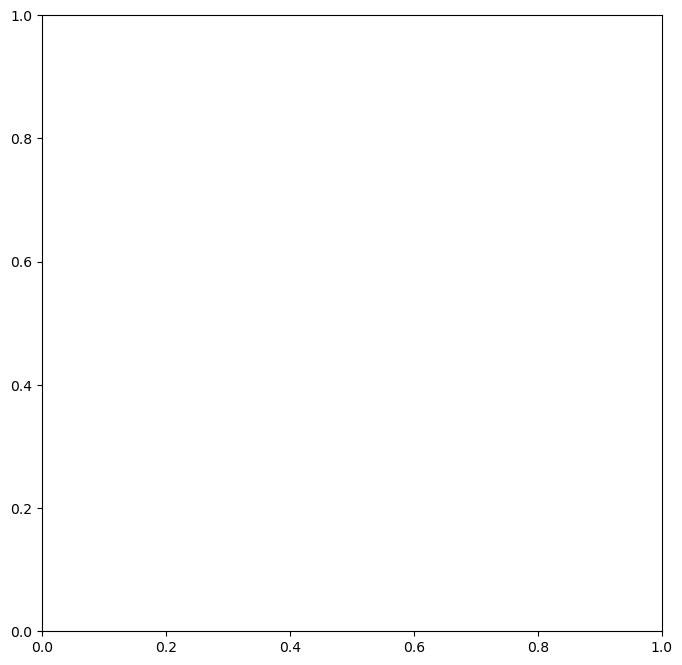

In [39]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
# xx.isel(time=time_slice)[[common_to_band["red"],common_to_band["green"],common_to_band["blue"]]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
data_sen_2_l2a.isel(time=4)[["red","green","blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
# ax.set_title("RGB Real Color")
# ax.axis('off')
# plt.show()

### Apply Cloud Filtering and Masking

In [116]:
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water 
# scl=8 > Cloud Medium Probability 
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

In [117]:
# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [118]:
def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

In [119]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.isel(time=time_slice).SCL.compute(), scl_colormap)

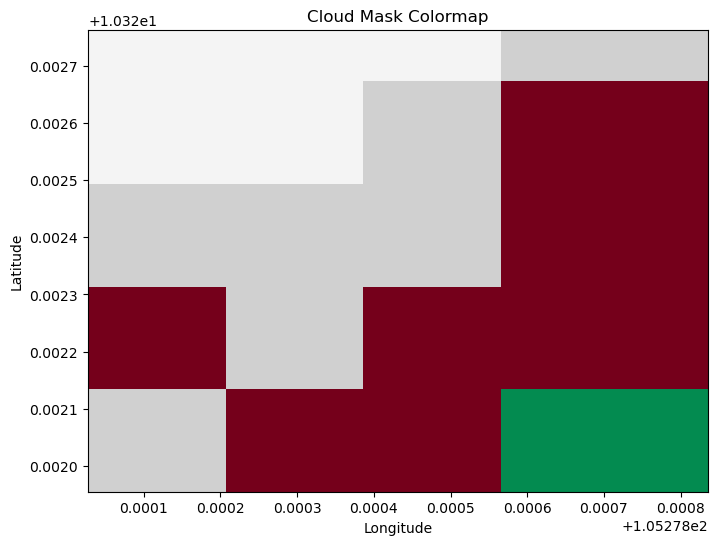

In [120]:
# Create an RGB plot of the SCL band
# Notice the clouds are bright white and the cloud shadows are grey

scl_rgba.plot.imshow(size=6)
plt.title("Cloud Mask Colormap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [121]:
# Create a mask for no data, saturated data, clouds, cloud shadows, and water

cloud_mask = \
    (xx.SCL != 0) & \
    (xx.SCL != 1) & \
    (xx.SCL != 3) & \
    (xx.SCL != 6) & \
    (xx.SCL != 8) & \
    (xx.SCL != 9) & \
    (xx.SCL != 10) 

In [122]:
# Apply cloud mask ... NO Clouds, NO Cloud Shadows and NO Water pixels
# All masked pixels are converted to "No Data" and stored as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [123]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba_clean = colorize(cleaned_data.isel(time=time_slice).SCL.compute(), scl_colormap)

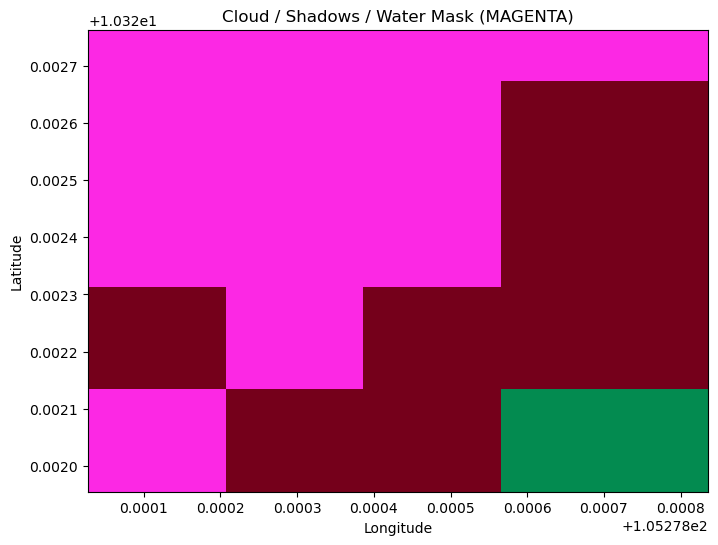

In [124]:
# Create an RGB plot of the SCL band
# Masked data (clouds/shadows/water) are shown in MAGENTA

scl_rgba_clean.plot.imshow(size=6)
plt.title("Cloud / Shadows / Water Mask (MAGENTA)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water), middle values (0.25 to 0.6) reflect crops in their growing state, and high values (0.6 to 1.0) reflect crops at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).
    
The NDVI plot below shows all (unfiltered) pixels (BLUE) and filtered pixels (GREEN). In cases where the filtered data is entirely masked out, it is possible there are no available "clean" pixels to calculate NDVI. This is why there are sometimes "gaps" in the filtered dataset (GREEN) and the line has "gaps". At times when the filtered and unfiltered NDVI values are similar, this suggests low cloud volume in the sample. At times where the filtered and unfiltered NDVI values are very different, this suggests high cloud volume in the sample which tends to adversely lower NDVI. For these reasons, it is important to filter clouds out of the data before calculating NDVI for a given region coincident with an agriculture plot. This will yield the most accurate phenology results.

In [125]:
mean_unfiltered

<xarray.Dataset>
Dimensions:      (time: 67)
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-01-05T03:21:29.024000 ... 2021-12...
Data variables: (12/16)
    AOT          (time) float64 204.0 126.0 138.0 204.0 ... 222.0 144.0 126.0
    B01          (time) float64 8.735e+03 769.2 788.3 ... 447.9 915.8 313.1
    B02          (time) float64 7.715e+03 739.0 676.7 ... 582.8 803.1 455.9
    B03          (time) float64 7.133e+03 966.0 904.1 ... 735.2 877.6 691.3
    B04          (time) float64 6.616e+03 672.8 496.1 ... 737.1 717.0 462.6
    B05          (time) float64 7.202e+03 1.181e+03 1.088e+03 ... 961.3 880.1
    ...           ...
    B11          (time) float64 2.752e+03 1.484e+03 1.814e+03 ... 400.6 854.0
    B12          (time) float64 2.149e+03 957.1 1.011e+03 ... 108.0 271.1 547.6
    B8A          (time) float64 6.56e+03 2.594e+03 3.236e+03 ... 988.4 1.589e+03
    SCL          (time) float64 9.0 10.0 4.0 9.049 ... 6.753 2.494 2.926 4.432
    WVP          (time) float64 3.334e+03 3.525e+03 ... 4.347e+03 4.089e+03
    visual       (time) float64 255.0 68.86 50.9 246.7 ... 75.41 73.36 47.49

In [126]:
# Calculate the mean of the data across the sample region and then NDVI
# Perform this calculation for the unfiltered and cloud-filtered (clean) datasets
mean_unfiltered = xx.mean(dim=['longitude','latitude']).compute()
ndvi_mean = (mean_unfiltered.nir-mean_unfiltered.red)/(mean_unfiltered.nir+mean_unfiltered.red)
mean_clean = cleaned_data.mean(dim=['longitude','latitude']).compute()
ndvi_mean_clean = (mean_clean.nir-mean_clean.red)/(mean_clean.nir+mean_clean.red)

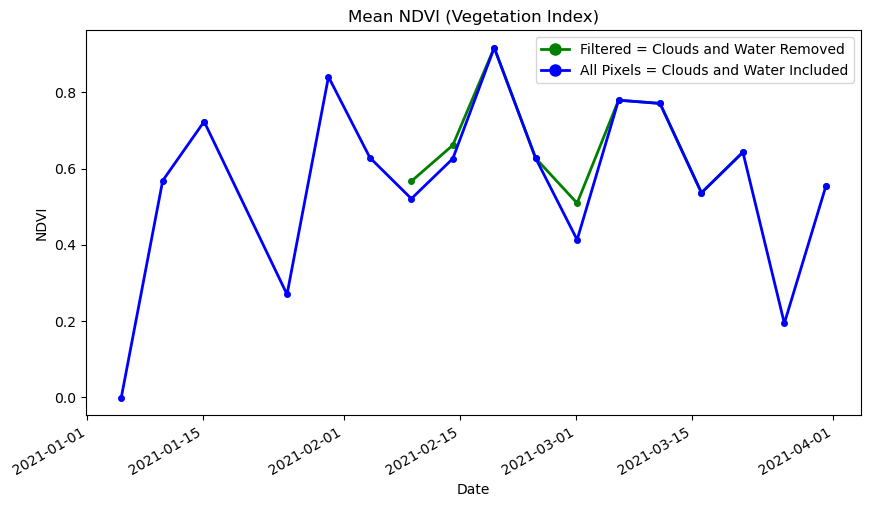

In [129]:
fig = plt.figure(figsize=(10, 5))
ndvi_mean_clean.plot(color='green',marker='o',markersize=4,linewidth=2, label="Filtered = Clouds and Water Removed")
ndvi_mean.plot(color='blue',marker='o',markersize=4,linewidth=2, label="All Pixels = Clouds and Water Included")
plt.title("Mean NDVI (Vegetation Index)")
plt.xlabel("Date")
plt.ylabel("NDVI")
# plt.ylim(-0.1,0.7)
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=10)
plt.show()

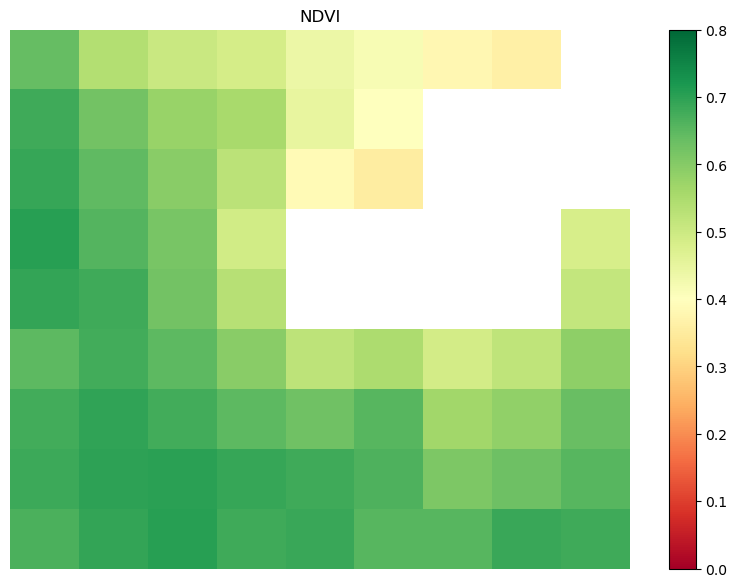

In [128]:
# Plot an NDVI image for a single date with few clouds
# We will select image (index=6) on December 31, 2021. Notice how the water is masked out.

fig = plt.figure(figsize=(10, 7))
ndvi_image = (cleaned_data.nir-cleaned_data.red)/(cleaned_data.nir+cleaned_data.red)
ndvi_image.isel(time=6).plot(vmin=0.0, vmax=0.8, cmap="RdYlGn")
plt.title("NDVI")
plt.axis('off')
plt.show()